# DCGAN Architecture

This notebook contains the architecture for DCGAN. The generated images and losses from both generator and discriminator are plotted periodically. This arrangement starts giving decent results after around 3000 epochs with a batch size of 16

In [0]:
# Basic imports
import os
import time
import functools

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import h5py
%matplotlib inline

## Collecting the Celebrity dataset

We've preprocessed the img_align_celeba dataset to be sized in the dimensions (64,64,3) and selected 100 images out of the total (more then 200,000) to be used for training the GAN. We converted the dataset to a h5 file and uploaded it to our google drive.


In [9]:
# Downloading the dataset
!gdown --id 13joZ-UoutLoMPOlyonosG3Gg0Ps7GMKY

Downloading...
From: https://drive.google.com/uc?id=13joZ-UoutLoMPOlyonosG3Gg0Ps7GMKY
To: /content/celeba_dataset.h5
4.92MB [00:00, 153MB/s]


Here we create a generator and an ImgeUtil class to read images in h5 format and pass them to tensorflow

In [0]:
# For reading the dataset
class Generator:
    def __init__(self, filename, key):
        self.filename = filename
        self.key = key

    def __call__(self):
        with h5py.File(self.filename, 'r') as f:
            for im in f[self.key]:
                yield im

class ImageUtil():
    def __init__(self, filename, key):
        self.filename = filename
        self.key = key

    def get_h5_images(self):
        gen = Generator(self.filename, self.key)
        dataset = tf.data.Dataset.from_generator(gen, tf.float32)
        return dataset

## Image Helper class

This class generates the random seed for the generator and saves those generated images if required. It also generates images required for claculating the FID

In [0]:
# Image Helper class
class ImageHelper():
    def __init__(self, noise_dim, num_examples_to_generate=16, img_dir='images'):
        try:
            os.mkdir(img_dir)
        except OSError as error:
            pass
        self.img_dir = img_dir
        self.seed = tf.random.normal([num_examples_to_generate, noise_dim])

    def generate_and_save_images(self, model, epoch):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(self.seed, training=False)

        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow((predictions[i, :, :, :] + 1) / 2.0)
            plt.axis('off')

        plt.savefig('{}/image_at_epoch_{:04d}.png'.format(self.img_dir, epoch))
        #plt.show()

    def generate_images_for_FID(self,model,noise_dim,n_images):
        seed = tf.random.normal([n_images, noise_dim])
        predictions = model(seed, training=False)
        return predictions

## GAN class
This is the main class that contains declarations for generator, discriminator, their corresponding loss functions and training steps. We keep track of the discriminator's real and fake loss, and generator's loss as well.

In [0]:
# GAN class
class GAN():
    def __init__(self, buffer_size=6000, batch_size=1000, epochs=8000, noise_dim=100, filename='celeba_dataset.h5'):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.noise_dim = noise_dim
        self.train_dataset = ImageUtil(filename=filename, key='celeba').get_h5_images()
        self.train_dataset = self.train_dataset.shuffle(buffer_size).batch(batch_size)
        self.graphs = {}

    def _make_generator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(4 * 4 * 1024, use_bias=False, input_shape=(self.noise_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((4, 4, 1024)))
        assert model.output_shape == (None, 4, 4, 1024)  # Note: None is the batch size

        model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        assert model.output_shape == (None, 4, 4, 512)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 8, 8, 256)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 16, 16, 128)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 32, 32, 64)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, 64, 64, 3)

        return model


    def _make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[64, 64, 3]))
        assert model.output_shape == (None, 32, 32, 64)
        model.add(layers.LeakyReLU())

        model.add(layers.Dropout(0.3))
        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        assert model.output_shape == (None, 16, 16, 128)
        model.add(layers.LeakyReLU())

        model.add(layers.Dropout(0.3))
        model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
        assert model.output_shape == (None, 8, 8, 256)
        model.add(layers.LeakyReLU())

        model.add(layers.Dropout(0.3))
        model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
        assert model.output_shape == (None, 4, 4, 512)
        model.add(layers.LeakyReLU())

        model.add(layers.Dropout(0.3))
        model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
        assert model.output_shape == (None, 2, 2, 1024)
        model.add(layers.LeakyReLU())

        model.add(layers.Dropout(0.3))
        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model


    def _discriminator_loss(self, cross_entropy, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss, real_loss, fake_loss

    def _generator_loss(self, cross_entropy, fake_output):
        fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        return fake_loss

    @tf.function
    def _train_step(self,
                    images,
                    generator,
                    discriminator,
                    generator_optimizer,
                    discriminator_optimizer,
                    cross_entropy,
                    batch_size):
        noise = tf.random.normal([batch_size, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            gen_loss = self._generator_loss(cross_entropy, fake_output)
            disc_loss, disc_real_loss, disc_fake_loss = self._discriminator_loss(cross_entropy, real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return disc_real_loss, disc_fake_loss, gen_loss

    def train(self, checkpoint_dir='./training_checkpoints'):
        generator = self._make_generator_model()
        generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        discriminator = self._make_discriminator_model()
        discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                         discriminator_optimizer=discriminator_optimizer,
                                         generator=generator,
                                         discriminator=discriminator)

        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        image_helper = ImageHelper(noise_dim=self.noise_dim)

        avg_disc_real_loss, avg_disc_fake_loss, avg_gen_loss = [], [], []
        print("Starting epochs...")
        for epoch in range(self.epochs):
            start = time.time()
            for image_batch in self.train_dataset:
                d_real_loss_vals, d_fake_loss_vals, g_loss_vals = [], [], []

                disc_real_loss, disc_fake_loss, g_loss = self._train_step(image_batch,generator,discriminator,generator_optimizer,discriminator_optimizer,cross_entropy,self.batch_size)

                d_real_loss_vals.append(float(disc_real_loss))
                d_fake_loss_vals.append(float(disc_fake_loss))
                g_loss_vals.append(float(g_loss))

            avg_disc_real_loss.append(np.mean(d_real_loss_vals))
            avg_disc_fake_loss.append(np.mean(d_fake_loss_vals))
            avg_gen_loss.append(np.mean(g_loss_vals))

            if (epoch + 1) % 5 == 0:
                # Save sample images from generator
                image_helper.generate_and_save_images(generator, epoch+1)
                # Graphs about losses
                self.graphs = {"avg_disc_real_loss":avg_disc_real_loss, "avg_disc_fake_loss":avg_disc_fake_loss  , "avg_gen_loss": avg_gen_loss}
                #self._epochs_vs_loss()

            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            print("Epoch " + str(epoch + 1) + "- Real Discriminator Loss:", np.mean(avg_disc_real_loss),
              "Fake Discriminator Loss:", np.mean(avg_disc_fake_loss),
              "Generator Loss:", np.mean(avg_gen_loss))
            print("\n")

        # Generate after the final epoch
        image_helper.generate_and_save_images(generator, self.epochs)

    def _epochs_vs_loss(self):
        fig = plt.figure(figsize=(12,8))
        # Generating loss graph
        L = len(self.graphs["avg_gen_loss"])
        plt.plot(range(L), self.graphs["avg_gen_loss"], "-b", label='generator loss')
        plt.plot(range(L), self.graphs["avg_disc_real_loss"], "-r", label='real discriminator loss')
        plt.plot(range(L), self.graphs["avg_disc_fake_loss"], "-y", label='fake discriminator loss')
        plt.legend(loc="upper left")
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()
        plt.savefig('epochs_vs_loss.png')

Here, we've supressed the displaying of generated images and the loss graph. THis is because they only make sense and give meaningful results after around 3000 epochs, which woul take too long to run on Google Collab. The results that we got from running the same code on a Nvidia RTX 2070 Super have been provided in the final report

Starting epochs...
Time for epoch 1 is 65.91362524032593 sec
Epoch 1- Real Discriminator Loss: 0.32539844512939453 Fake Discriminator Loss: 0.7192497253417969 Generator Loss: 0.6691931486129761


Time for epoch 2 is 62.86860752105713 sec
Epoch 2- Real Discriminator Loss: 0.24125002324581146 Fake Discriminator Loss: 0.4702787846326828 Generator Loss: 1.1517156958580017


Time for epoch 3 is 62.14052605628967 sec
Epoch 3- Real Discriminator Loss: 0.1614336520433426 Fake Discriminator Loss: 0.36088769137859344 Generator Loss: 1.4905840158462524


Time for epoch 4 is 61.941291093826294 sec
Epoch 4- Real Discriminator Loss: 0.12214237148873508 Fake Discriminator Loss: 0.3195083476603031 Generator Loss: 1.6320444643497467


Time for epoch 5 is 63.41938924789429 sec
Epoch 5- Real Discriminator Loss: 0.09867899017408491 Fake Discriminator Loss: 0.2660749062895775 Generator Loss: 1.975148606300354


Time for epoch 6 is 62.25526833534241 sec
Epoch 6- Real Discriminator Loss: 0.08579160591276984 

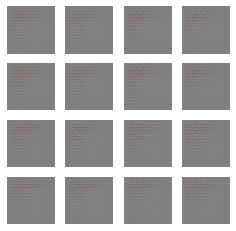

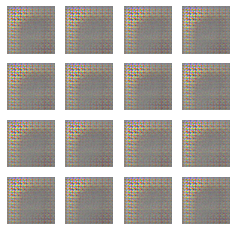

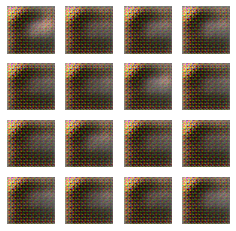

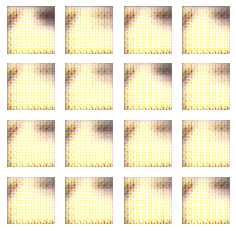

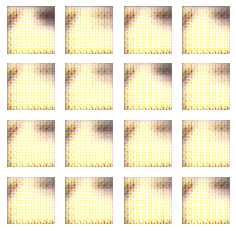

In [13]:
# Main
G = GAN(buffer_size=6000, batch_size=16, epochs=20)
G.train()